# HW 2

In [136]:
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import os

In [137]:
%config InlineBackend.figure_format = "retina"
mpl.rcParams['figure.dpi'] = 100

## Util functions

In [196]:
def visualize_fft_channels(fft_shifted):
    """
    Visualize the magnitude spectrum of the Fourier transform for RGB channels.
    
    Parameters:
    fft_shifted (numpy.ndarray): The shifted Fourier transform of an RGB image.
                                 Shape should be (height, width, 3).
    """
    # Ensure the input is 3D (height, width, 3 channels)
    if len(fft_shifted.shape) != 3 or fft_shifted.shape[2] != 3:
        raise ValueError("Input must be a 3D array with shape (height, width, 3)")

    # Calculate the magnitude spectrum for each channel
    magnitude_spectrum_r = np.log(np.abs(fft_shifted[:,:,0]) + 1)
    magnitude_spectrum_g = np.log(np.abs(fft_shifted[:,:,1]) + 1)
    magnitude_spectrum_b = np.log(np.abs(fft_shifted[:,:,2]) + 1)

    # Create a figure with 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle('Fourier Transform Magnitude Spectrum', fontsize=16)

    # Plot R channel
    axs[0, 0].imshow(magnitude_spectrum_r, cmap='hot')
    axs[0, 0].set_title('Red Channel')
    axs[0, 0].axis('off')

    # Plot G channel
    axs[0, 1].imshow(magnitude_spectrum_g, cmap='hot')
    axs[0, 1].set_title('Green Channel')
    axs[0, 1].axis('off')

    # Plot B channel
    axs[1, 0].imshow(magnitude_spectrum_b, cmap='hot')
    axs[1, 0].set_title('Blue Channel')
    axs[1, 0].axis('off')

    # Plot RGB combined
    rgb_magnitude = np.stack((
        magnitude_spectrum_r / np.max(magnitude_spectrum_r),
        magnitude_spectrum_g / np.max(magnitude_spectrum_g),
        magnitude_spectrum_b / np.max(magnitude_spectrum_b)
    ), axis=2)
    axs[1, 1].imshow(rgb_magnitude)
    axs[1, 1].set_title('RGB Combined')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_images_side_by_side(image1, image2, title1="Image 1", title2="Image 2", figsize=(12, 6)):
    """
    Plot two images side by side using matplotlib.
    
    Parameters:
    image1 (numpy.ndarray): The first image to plot.
    image2 (numpy.ndarray): The second image to plot.
    title1 (str): Title for the first image. Default is "Image 1".
    title2 (str): Title for the second image. Default is "Image 2".
    figsize (tuple): Figure size (width, height) in inches. Default is (12, 6).
    
    Note: This function assumes that both images are either both grayscale or both RGB.
    """
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Image Comparison', fontsize=16)

    # Plot the first image
    if len(image1.shape) == 2 or image1.shape[2] == 1:  # Grayscale
        im1 = ax1.imshow(image1, cmap='gray')
    else:  # RGB
        im1 = ax1.imshow(image1)
    ax1.set_title(title1)
    ax1.axis('off')

    # Plot the second image
    if len(image2.shape) == 2 or image2.shape[2] == 1:  # Grayscale
        im2 = ax2.imshow(image2, cmap='gray')
    else:  # RGB
        im2 = ax2.imshow(image2)
    ax2.set_title(title2)
    ax2.axis('off')

    # Add colorbars
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

## Load data

In [139]:
idx = 1
switch_order = False

In [140]:
images = glob.glob(f'data/task1and2_hybrid_pyramid/{idx}*')
assert len(images) == 2
if not switch_order:
    path_a, path_b = images
else:
    path_b, path_a = images

In [141]:
img_a = Image.open(path_a)
img_b = Image.open(path_b)

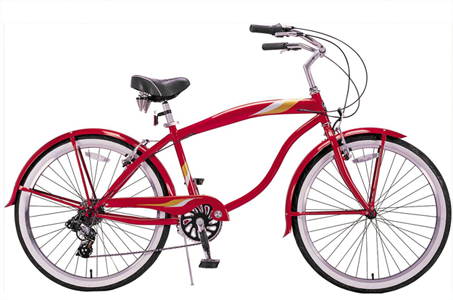

In [304]:
img_a

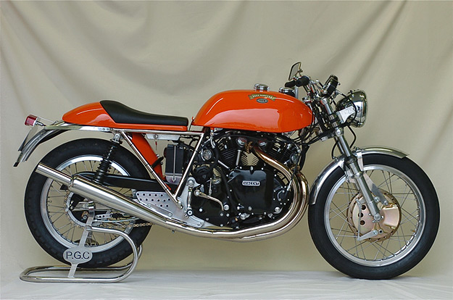

In [143]:
img_b

In [192]:
A = np.array(img_a)
B = np.array(img_b)

width = A.shape[1]
height = A.shape[0]
print(width, height)

453 300


## Conversion into frequency domain

In [314]:
def pos_to_freq(img):
    fft_r = np.fft.fft2(A[:,:,0])
    fft_g = np.fft.fft2(A[:,:,1])
    fft_b = np.fft.fft2(A[:,:,2])
    
    fft_combined = np.stack((fft_r, fft_g, fft_b), axis=2)
    fft_shifted = np.fft.fftshift(fft_combined)
    return fft_shifted

def freq_to_pos(fft_shifted):
    # Inverse shift
    fft_unshifted = np.fft.ifftshift(fft_shifted)
    
    # Separate channels
    fft_r = fft_unshifted[:,:,0]
    fft_g = fft_unshifted[:,:,1]
    fft_b = fft_unshifted[:,:,2]
    
    # Inverse FFT for each channel
    img_r = np.fft.ifft2(fft_r).real
    img_g = np.fft.ifft2(fft_g).real
    img_b = np.fft.ifft2(fft_b).real
    
    # Stack channels and ensure values are in valid range
    img = np.stack((img_r, img_g, img_b), axis=2)
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    return img

In [315]:
fft_shifted = pos_to_freq(A)

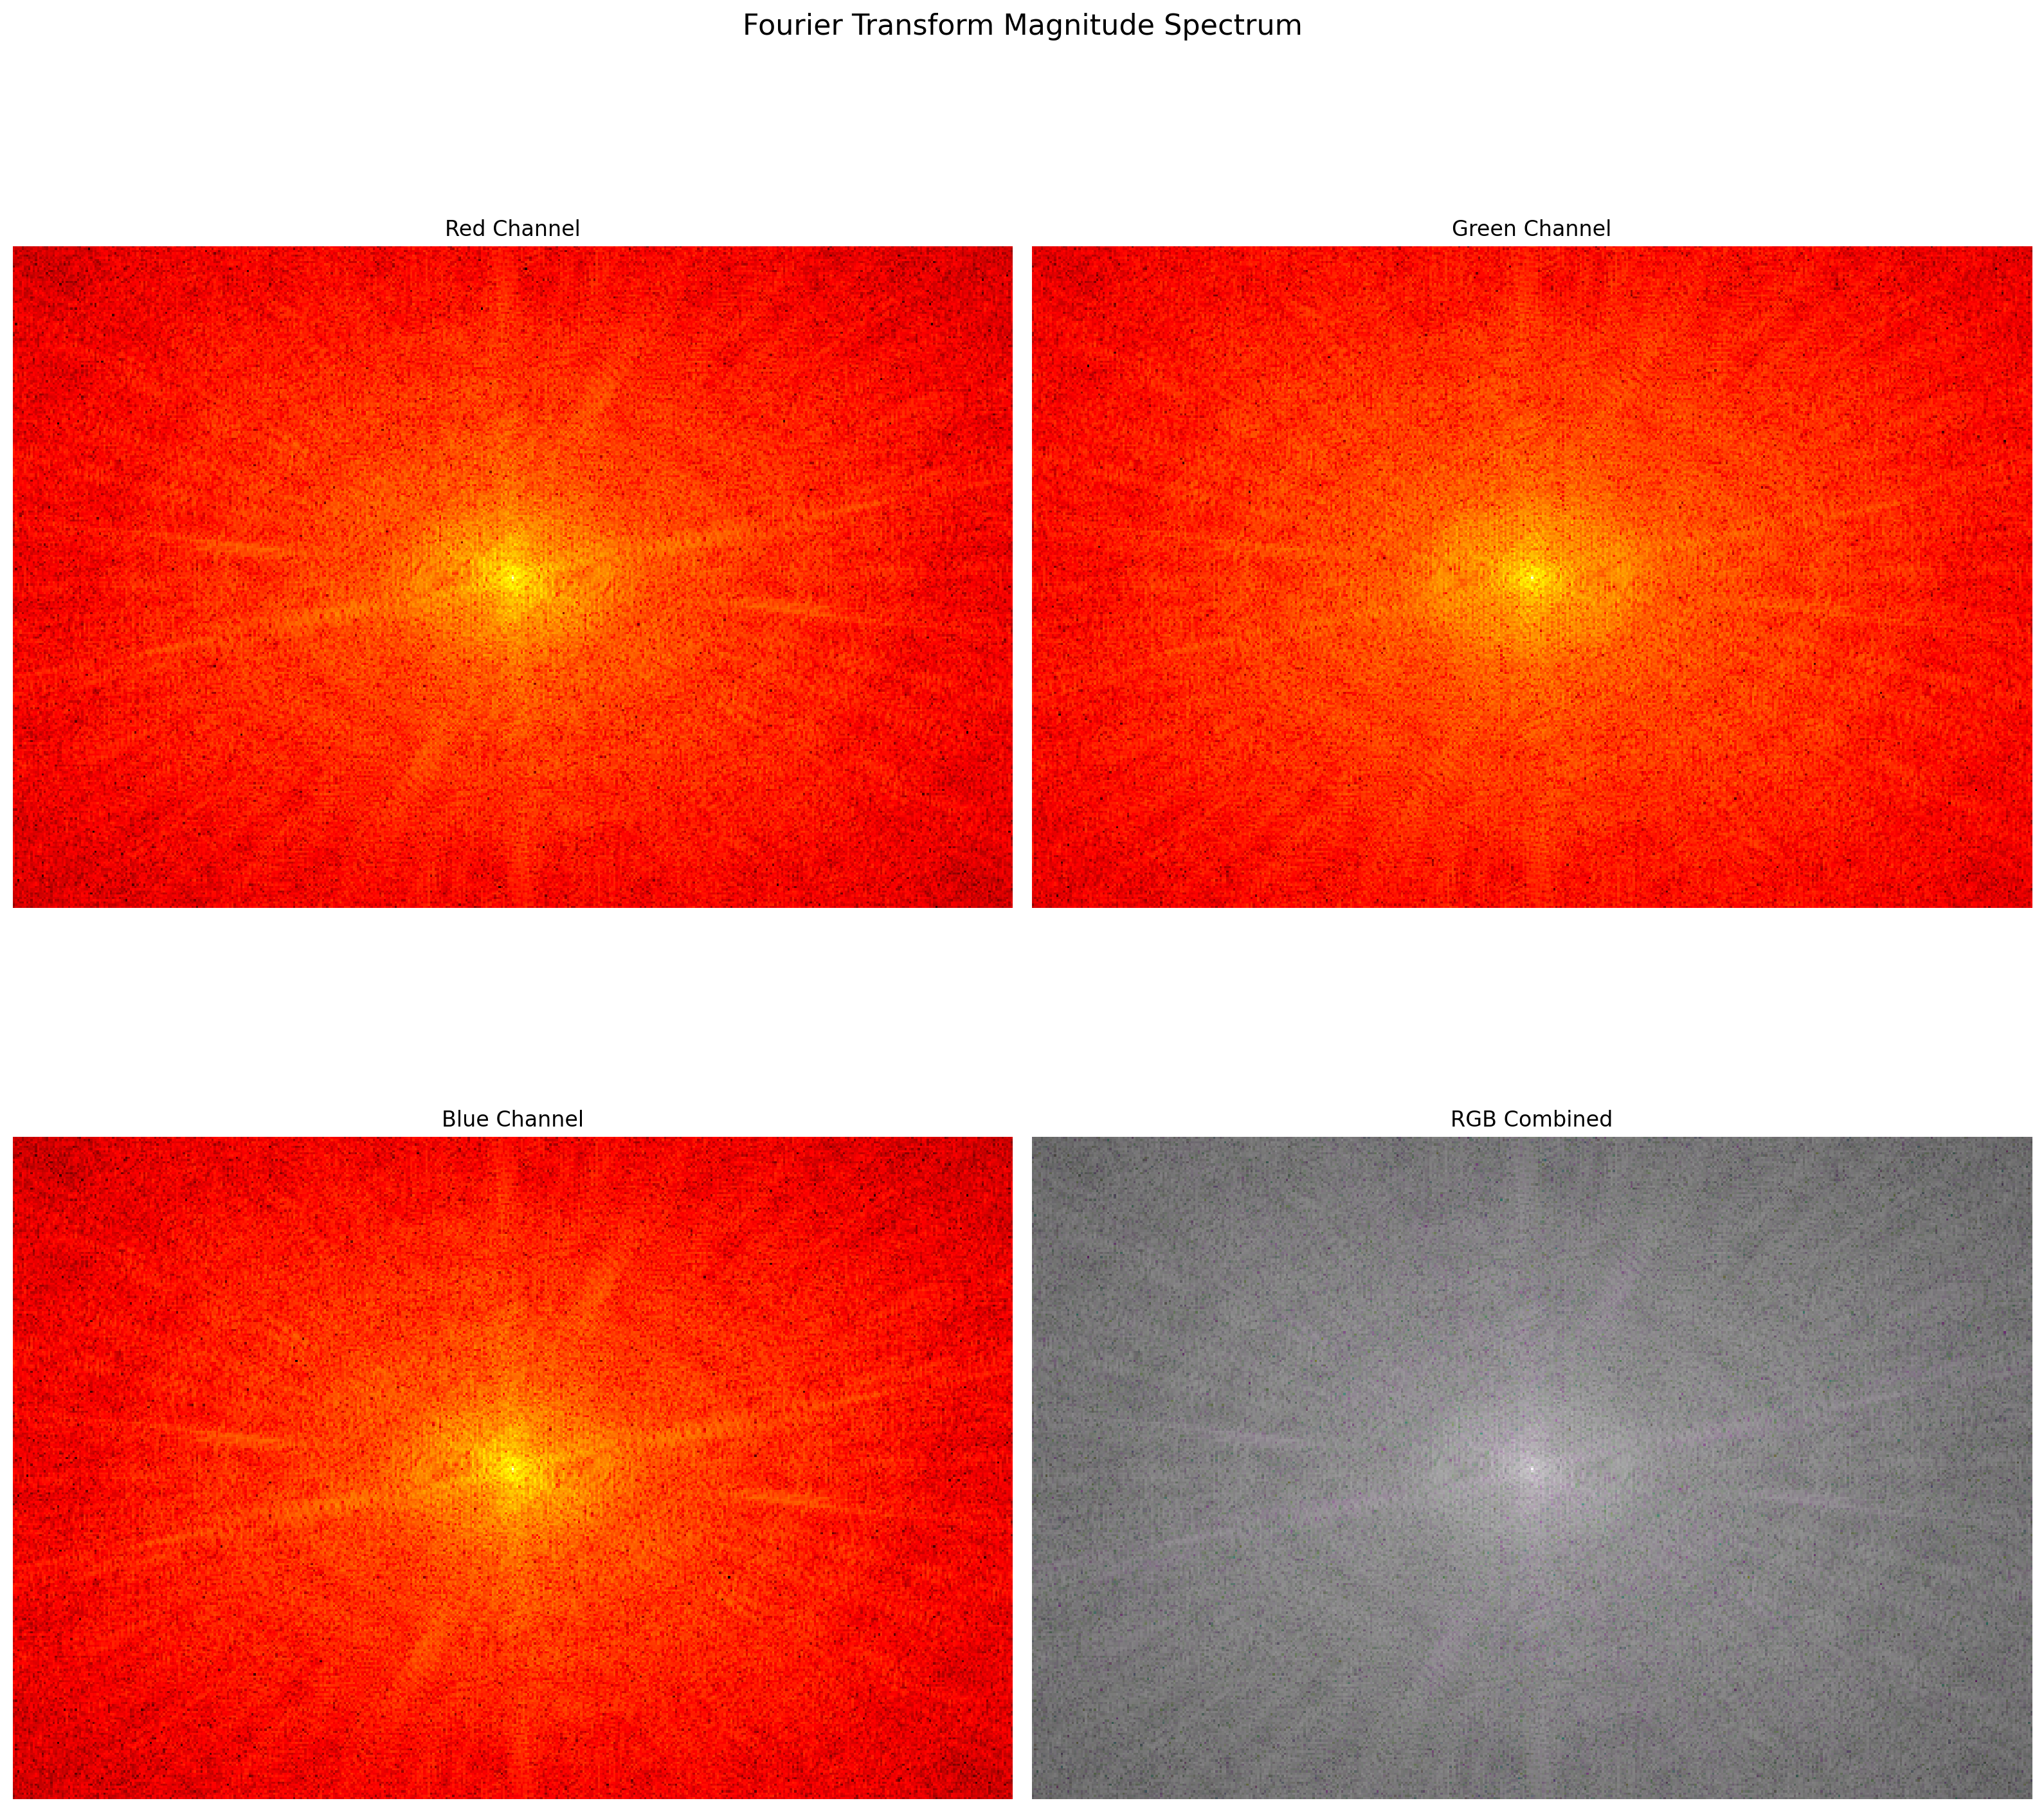

In [316]:
visualize_fft_channels(fft_shifted)

## Gaussian kernel

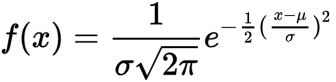


In [176]:
def normal_dist_pdf(x, sigma):
    return 1 / (sigma * np.sqrt(2*np.pi)) \
            * np.exp(-1/2 * (x/sigma)**2) 

norm_pdf(0) =  0.039894228040143274
1.0


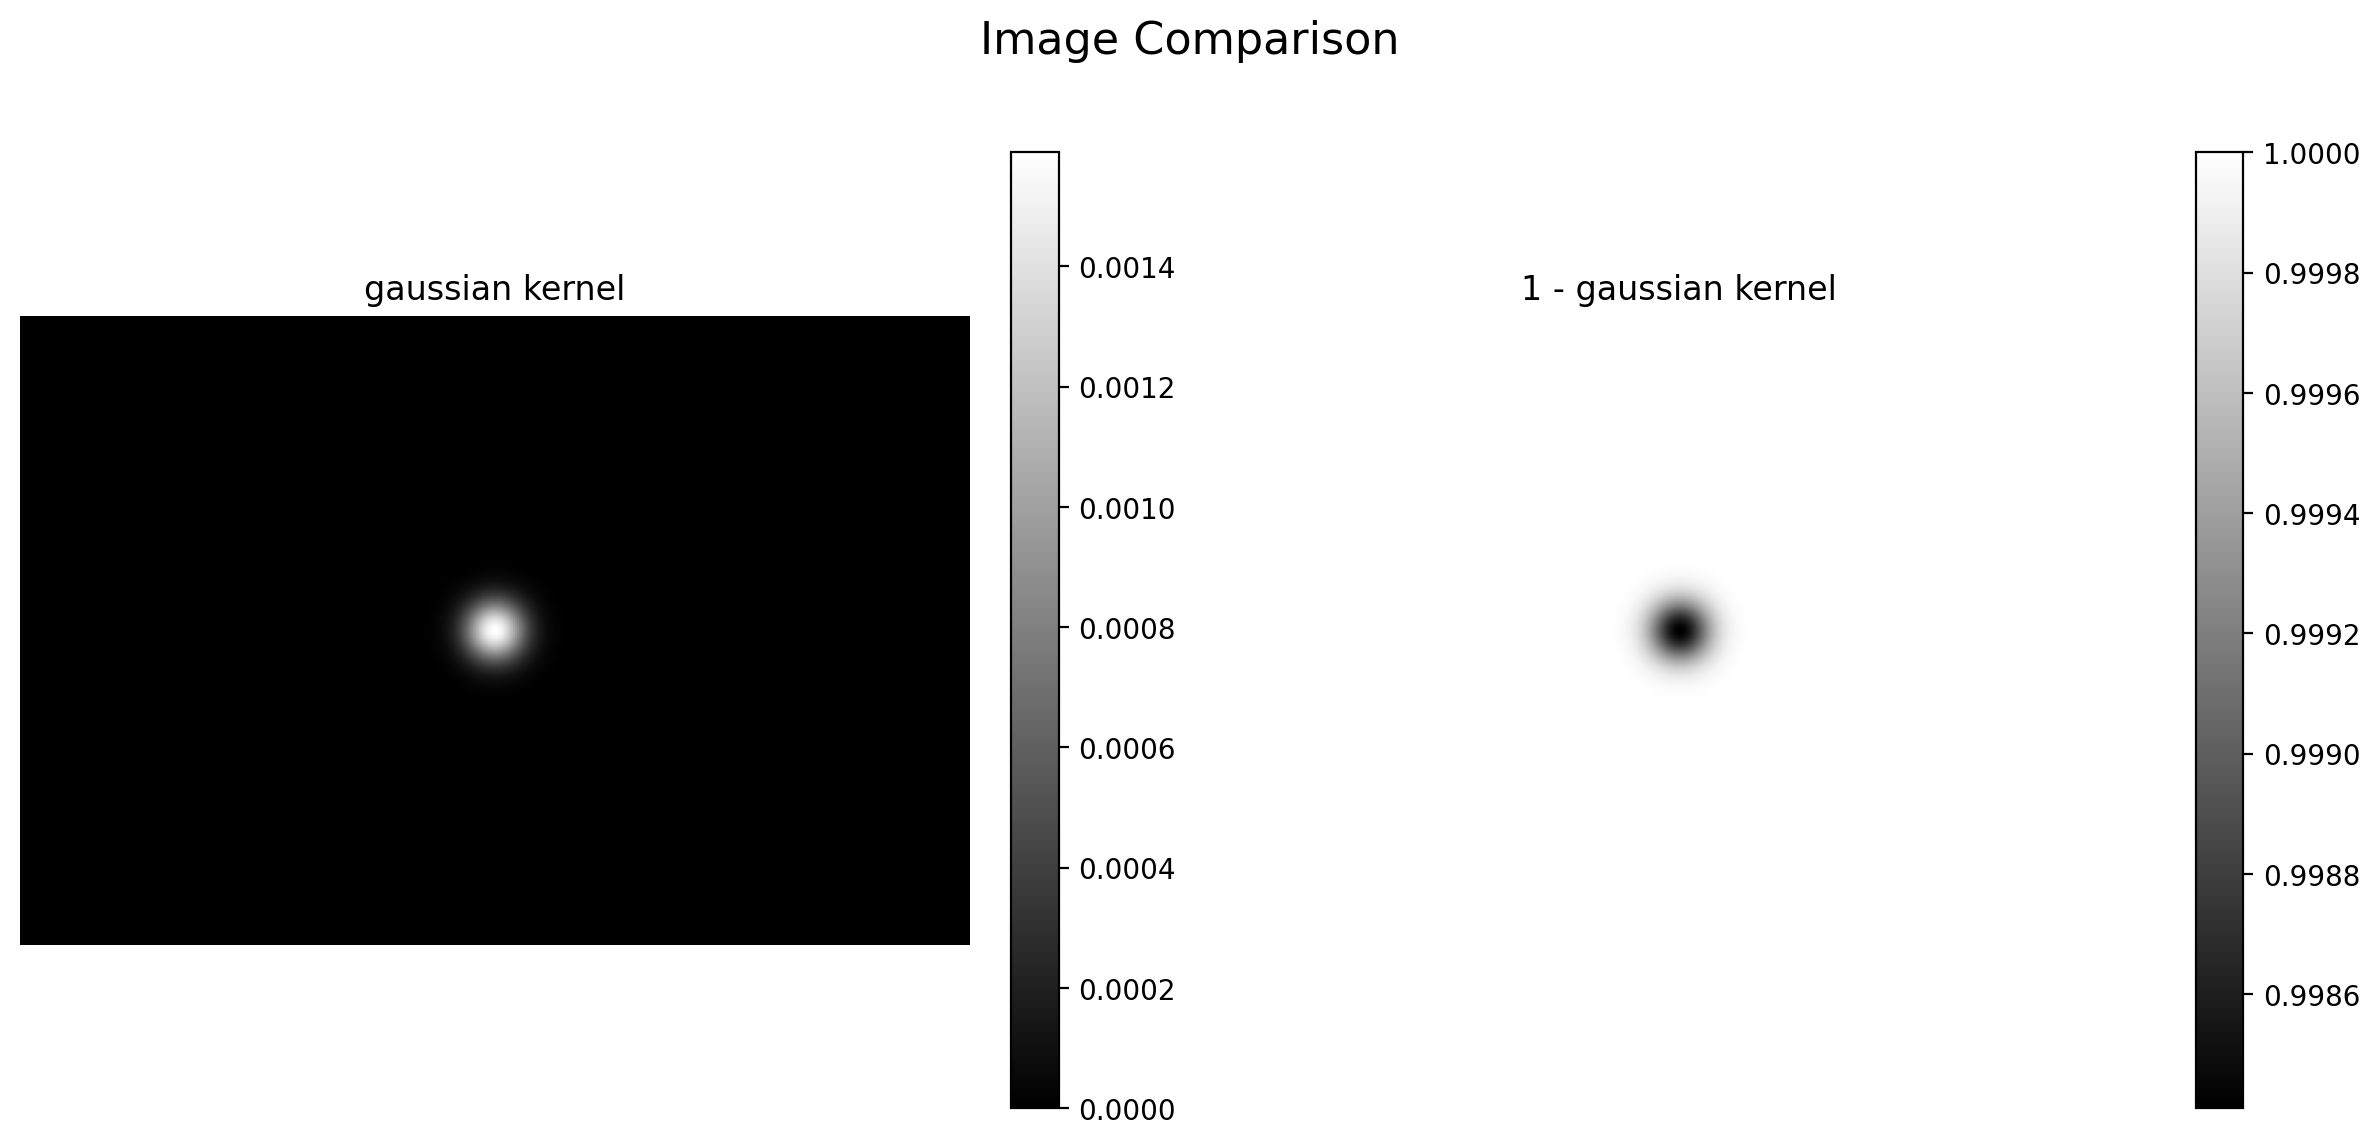

In [287]:
def gaussian_kernel_matrix(width, height, sigma):
    x = np.linspace(0,width - 1, width)
    y = np.linspace(0,height - 1, height)

    xv, yv = np.meshgrid(x,y)

    xc = (width - 1) / 2
    yc = (height - 1) / 2

    dist = np.sqrt((xv - xc)**2 + (yv - yc)**2)

    kernel = normal_dist_pdf(dist, sigma)

    # plt.imshow(kernel)

    

    kernel = kernel / np.sum(kernel)

    print('norm_pdf(0) = ',normal_dist_pdf(0, sigma))
    print(np.sum(kernel))
    return kernel


K_low_pass = gaussian_kernel_matrix(width,height,10)

K_high_pass = 1 -  K_low_pass 
# K_high_pass /= np.sum(K_high_pass)

plot_images_side_by_side(K_low_pass, K_high_pass, title1="gaussian kernel", title2="1 - gaussian kernel")

## Convolution in frequencyfft_shifted domain

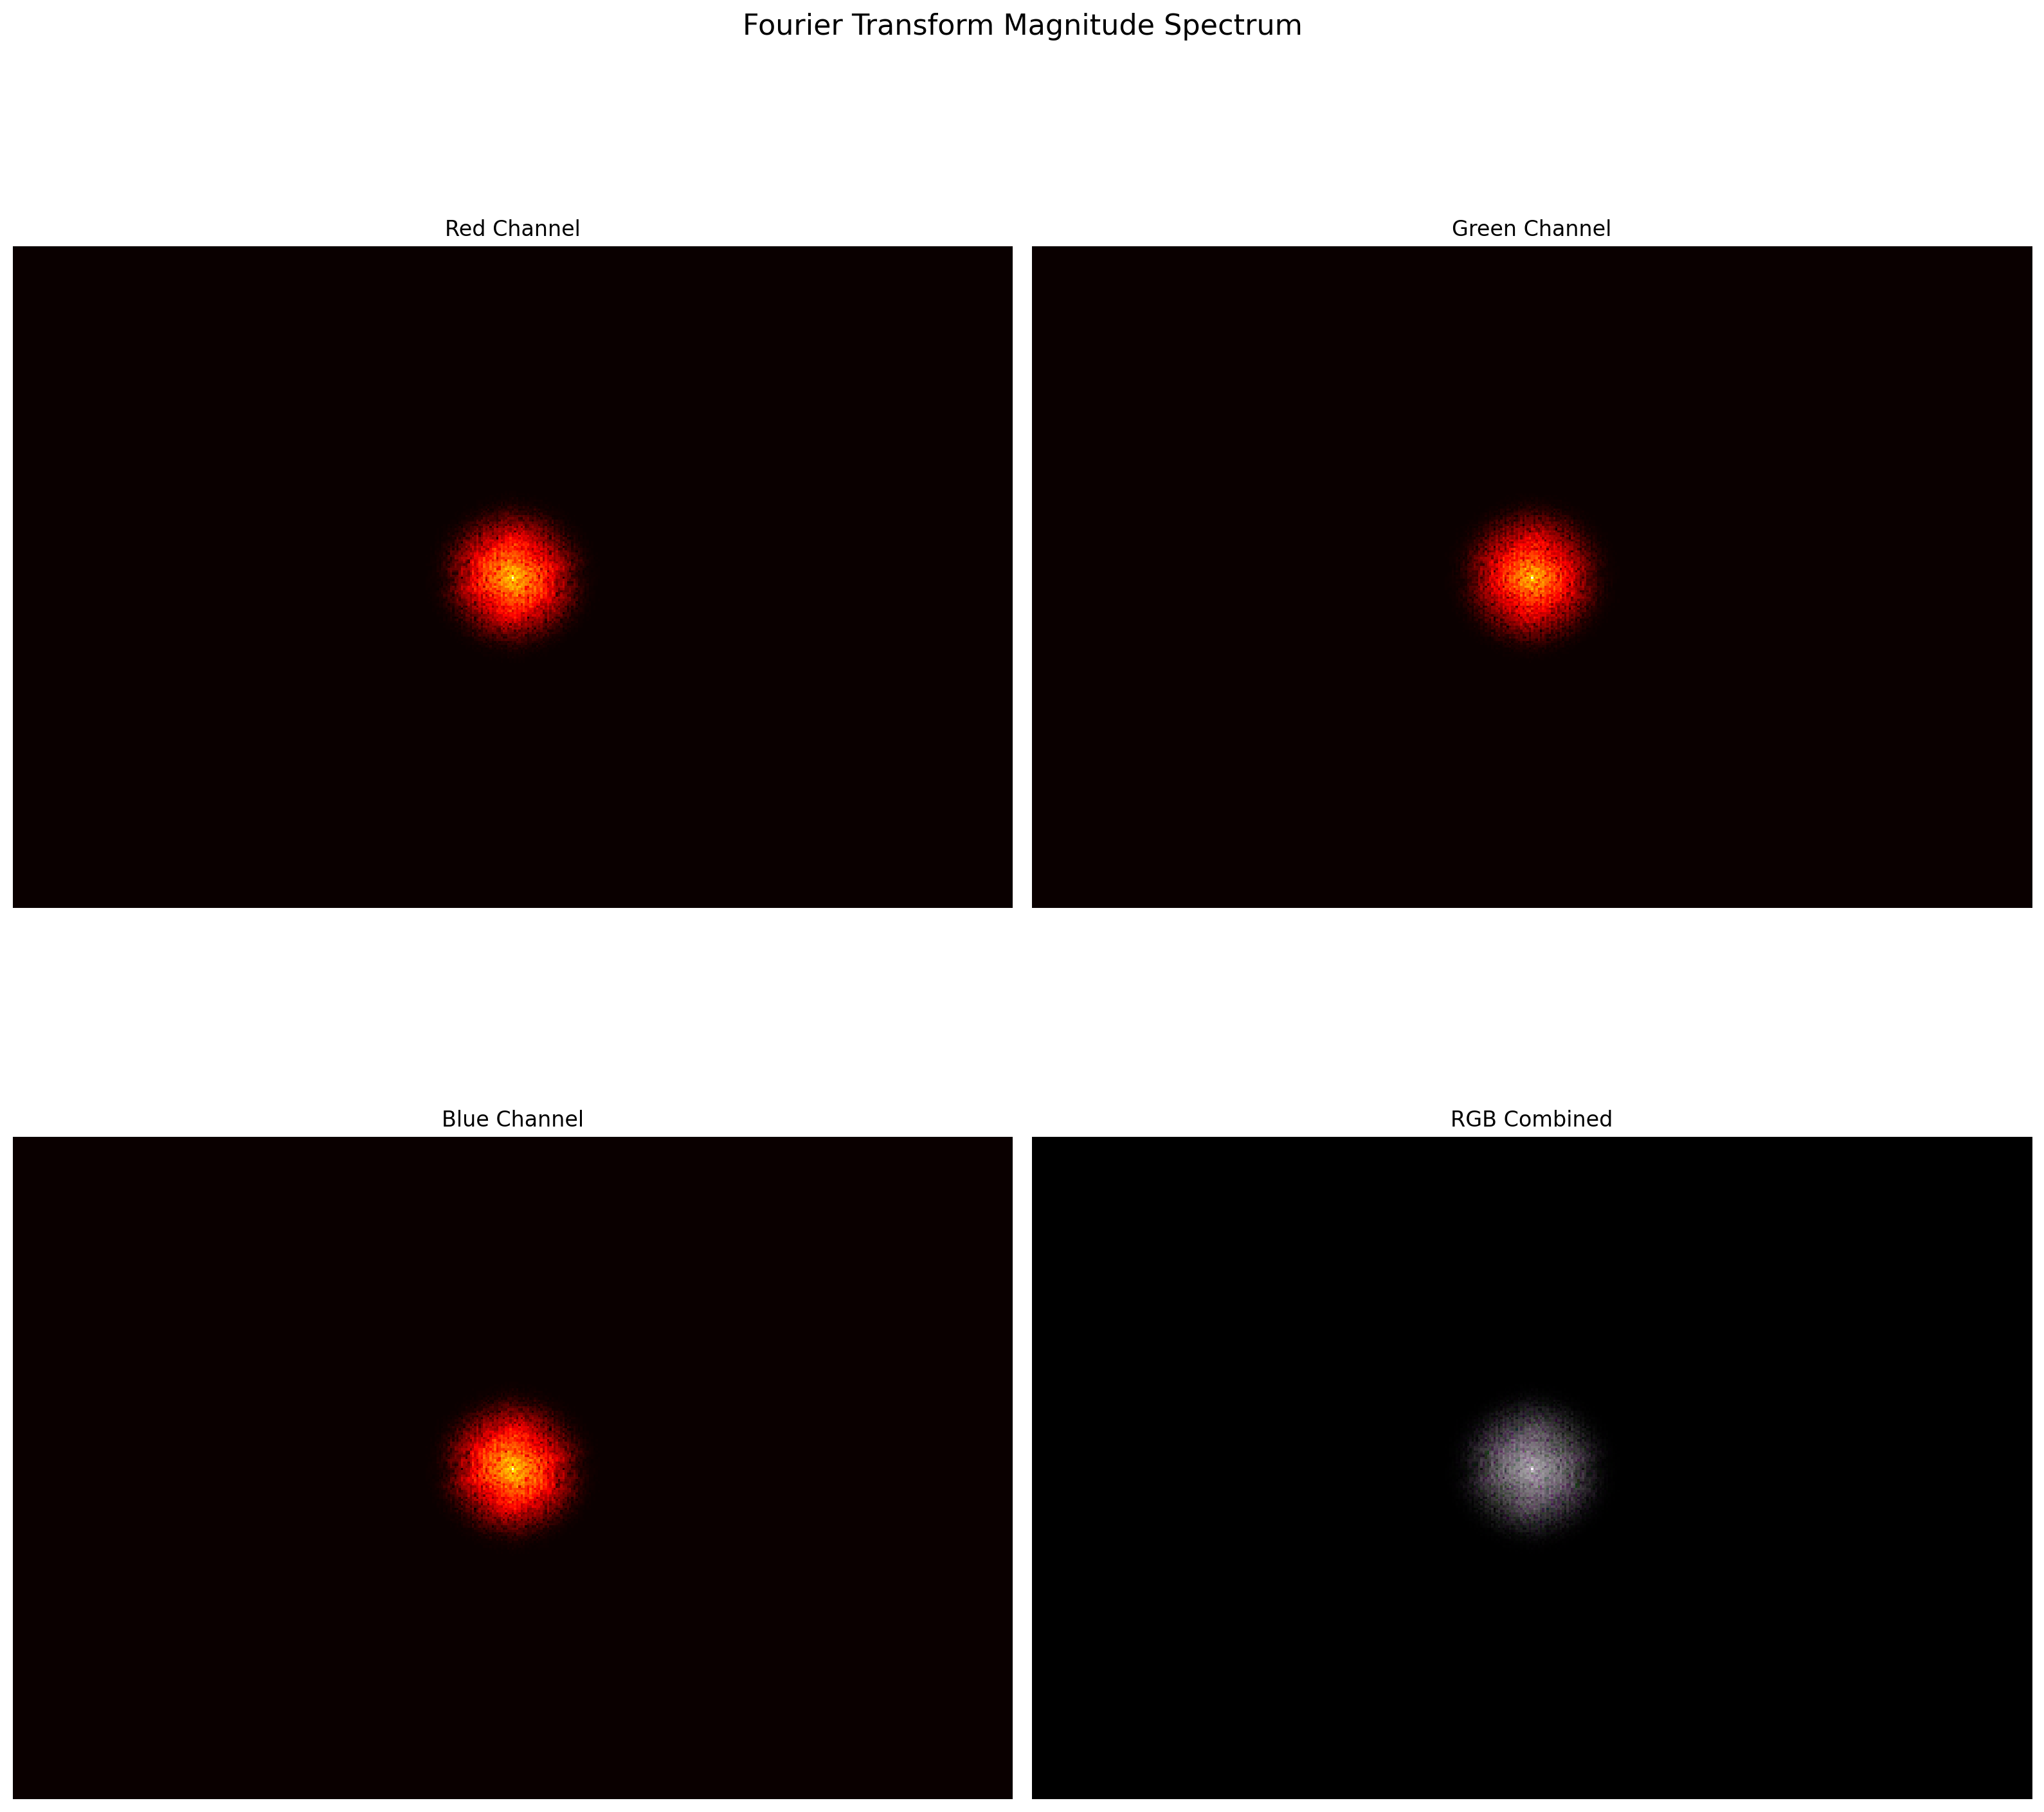

In [301]:
energy = np.sum(fft_shifted,axis=2)
A_2 = fft_shifted * K_low_pass[:, :, np.newaxis]
visualize_fft_channels(low_pass)

In [289]:
np.sum(A, axis=(0,1))

array([30632051, 28974118, 29343550], dtype=uint64)

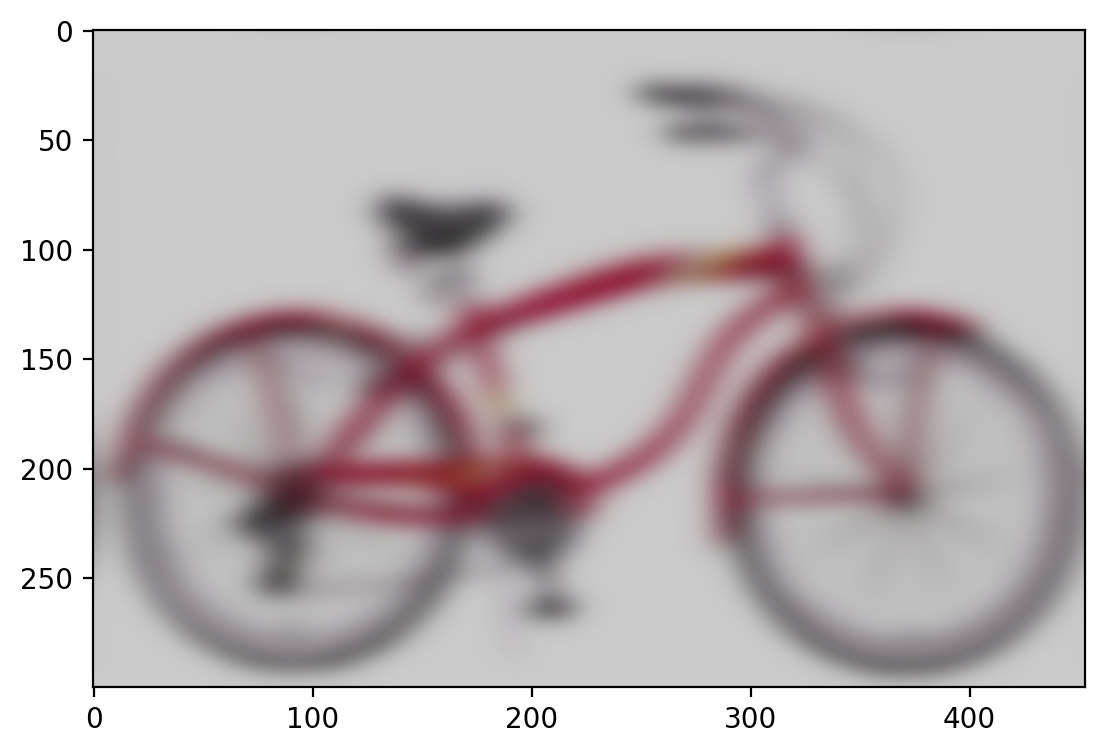

In [309]:
plt.imshow(freq_to_pos(low_pass * 500))

In [214]:
freq_to_pos(low_pass)[10,10,:]

array([0, 0, 0], dtype=uint8)